In [19]:
#all imports
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tqdm import tqdm_notebook
import re
import pickle
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.utils import to_categorical
import nltk
import sys
sys.path.append('/content')
import tokenization


In [20]:
!pip install sentencepiece

In [21]:
!pip install sentencepiece

In [22]:
tf.test.gpu_device_name()

'/device:GPU:0'

<pre><font size=6>Preprocessing</font></pre>

In [23]:
#Read the dataset - Amazon reviews
reviews = pd.read_csv(r"/content/data/Reviews.csv",engine='python',encoding='utf8',error_bad_lines=False)
#check the info of the dataset
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  60000 non-null  int64 
 1   Text        59994 non-null  object
 2   Score       60000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


In [24]:
#get only 2 columns - Text, Score
#drop the NAN values
reviews_cut = reviews[['Text','Score']]
reviews_cut.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [25]:
reviews_cut['Score'].value_counts()

0    29998
1    29996
Name: Score, dtype: int64

In [26]:
reviews=reviews_cut

In [27]:
def get_wordlen(x):
  return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<95]

In [28]:
reviews = reviews.reset_index(drop=True)

In [29]:
reviews.shape

(41939, 3)

In [30]:
#split the data into train and test data(20%) with Stratify sampling
X_train, X_test, y_train, y_test = train_test_split(reviews[['Text','len']], reviews[['Score']],shuffle=True,test_size=0.20, random_state=33)

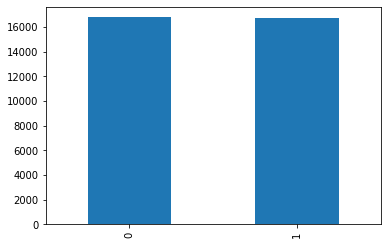

In [31]:
#plot bar graphs of y_train and y_test

y_train['Score'].value_counts().plot(kind='bar');

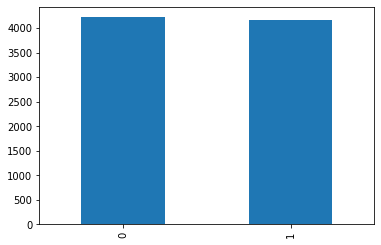

In [32]:
y_test['Score'].value_counts().plot(kind='bar');

In [33]:
#saving to disk
reviews.to_csv('data/preprocessed.csv', index=False)

<pre><font size=6>Creating BERT Model</font> 


In [34]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length
max_seq_length = 100

#input words
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors.
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2", trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model

bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

In [35]:
bert_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [36]:
bert_model.output

<tf.Tensor 'keras_layer/cond/Identity:0' shape=(None, 1024) dtype=float32>

<pre><font size=6>Tokenization</font></pre>

In [37]:
#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [38]:
#installing required module
#%pip install sentencepiece 

In [39]:
# Create tokenizer 
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case )


In [40]:
X_train.values[100]

array(['sorry but i have to give this 2 stars because it does not contain a single photo which is a must in any cookbook any cookbook author who does not know how to upload photo images really needs to learn how',
       41], dtype=object)

<pre><font size=6>Get 3 inputs of BERT</font></pre>

In [41]:
# Processing to get X_train_tokens, X_train_mask, X_train_segment
max_tokens = 100
X_train_tokens=[]
X_train_mask = []
X_train_segment = []
# iterate over X_train
for i in tqdm_notebook(range(len(X_train))):
    temp_tokens=tokenizer.tokenize(X_train.values[i][0])
    if len(temp_tokens)>= max_tokens-2:
        temp_tokens = temp_tokens[0:(max_tokens-2)]
    # adding [CLS] at start and [SEP] at end
    temp_tokens = ['[CLS]',*temp_tokens,'[SEP]']
    pad = max_tokens - len(temp_tokens)
    if pad > 0 :
        #adding Padding
        pads = ['[PAD]']*pad
        temp_tokens_fix = [*temp_tokens,*pads]
    else:
        temp_tokens_fix = temp_tokens
    tokens      = np.array(tokenizer.convert_tokens_to_ids(temp_tokens_fix))
    mask_tokens = np.array([1]*len(temp_tokens)+[0]*pad)
    seg_tokens  = np.array([0]*len(temp_tokens_fix))
    
    X_train_tokens.append(tokens)
    X_train_mask.append(mask_tokens)
    X_train_segment.append(seg_tokens)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [42]:
#Convert all into np.array
X_train_tokens = np.array(X_train_tokens)
X_train_mask = np.array(X_train_mask)
X_train_segment = np.array(X_train_segment)
y_train = np.array(y_train)

In [43]:
len(X_train_tokens[2])

100

In [44]:
X_train_tokens[0]

array([  101,  2023,  2003,  2107,  2019,  6429,  2338,  2009,  2018,
        2033, 16986,  2127,  1996,  2203,  1998,  1045,  2145,  2031,
        3980,  1045,  6187, 23961,  3524,  2000,  3191,  2338,  2048,
        2023,  2338,  3957,  1037,  2047,  3574,  2000,  2569,  3754,
        2064,  6586,  2741,  2011,  2643,  2428,  2444,  2426,  2149,
        2030,  2024,  2122,  2111,  2074,  8687, 12784,  3849,  2000,
        2228, 14992,  2890,  2003,  2062,  2000,  2009,  2035,  2330,
        2023,  2338,  1998,  2424,  2041,  2005,  4426,  1045,  2228,
        2017,  2097,  5959,  2009,  2004,  2172,  2004,  1045,  2106,
         102,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [45]:
# Processing to get X_test_tokens, X_test_mask, X_test_segment
max_tokens = 100
X_test_tokens=[]
X_test_mask = []
X_test_segment = []
# Iterate over X_test 
for i in tqdm_notebook(range(len(X_test))):
    # Tokenixe each review
    temp_tokens=tokenizer.tokenize(X_test.values[i][0])
    # Truncating if review is large 
    if len(temp_tokens)>= max_tokens-2:
        temp_tokens = temp_tokens[0:(max_tokens-2)]
    # adding [CLS] at start and [SEP] at end
    temp_tokens = ['[CLS]',*temp_tokens,'[SEP]']
    pad = max_tokens - len(temp_tokens)
    #adding Padding upto max token size
    if pad > 0 :
        pads = ['[PAD]']*pad
        temp_tokens_fix = [*temp_tokens,*pads]
    else:
        temp_tokens_fix = temp_tokens
    # Convert Tokens to ids
    tokens      = np.array(tokenizer.convert_tokens_to_ids(temp_tokens_fix))
    #Creating mask token and segment token of each review
    mask_tokens = np.array([1]*len(temp_tokens)+[0]*pad)
    seg_tokens  = np.array([0]*len(temp_tokens_fix))
    # Appending the review converted to id, the mask and segment tokens
    X_test_tokens.append(tokens)
    X_test_mask.append(mask_tokens)
    X_test_segment.append(seg_tokens)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [46]:
#Convert all into np.array
X_test_tokens = np.array(X_test_tokens)
X_test_mask = np.array(X_test_mask)
X_test_segment = np.array(X_test_segment)
y_test = np.array(y_test)

In [47]:
##save results 
pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, y_train),open('/content/model/train_data.pkl','wb'))
pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, y_test),open('/content/model/test_data.pkl','wb'))

In [48]:
#load data
X_train, X_train_tokens, X_train_mask, X_train_segment, y_train = pickle.load(open("/content/model/train_data.pkl", 'rb')) 
X_test, X_test_tokens, X_test_mask, X_test_segment, y_test = pickle.load(open("/content/model/test_data.pkl", 'rb')) 

In [49]:
bert_model.input

[<tf.Tensor 'input_word_ids:0' shape=(None, 100) dtype=int32>,
 <tf.Tensor 'input_mask:0' shape=(None, 100) dtype=int32>,
 <tf.Tensor 'segment_ids:0' shape=(None, 100) dtype=int32>]

In [50]:
bert_model.output

<tf.Tensor 'keras_layer/cond/Identity:0' shape=(None, 1024) dtype=float32>

In [51]:
# get the train output
X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

In [52]:
# get the test output
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

In [53]:
##save results
pickle.dump((X_train_pooled_output, X_test_pooled_output),open('/content/model/final_output.pkl','wb'))

In [54]:
#Load the results
X_train_pooled_output, X_test_pooled_output= pickle.load(open('/content/model/final_output.pkl', 'rb'))

In [55]:
y_train = pd.DataFrame(y_train,columns =['class']) 
y_train.head()

,class
0,1
1,1
2,1
3,0
4,0


In [56]:
y_test = pd.DataFrame(y_test,columns =['class'] ) 
y_test.head()

,class
0,1
1,0
2,1
3,1
4,1


In [57]:
print("y_train.shape      : ", y_train.shape)
print("len(y_train.shape) : ",len(y_train.shape))

y_train.shape      :  (33551, 1)
len(y_train.shape) :  2


In [58]:
print("y_test.shape      : ", y_test.shape)
print("len(y_test.shape) : ",len(y_test.shape))

y_test.shape      :  (8388, 1)
len(y_test.shape) :  2


In [59]:
##imports
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model

In [60]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [61]:
# One hot encoding Y_train and Y_test
Y_train_list = to_categorical(y_train['class'])
Y_test_list  = to_categorical(y_test['class'])
# Converting all into dataframe
Y_train_df = pd.DataFrame(Y_train_list) 
Y_test_df = pd.DataFrame(Y_test_list) 

In [62]:
#Selecting Best Hyperparameters for the neural netwoek
def best_hyperparameters(activ_mult,learn_rate_mult):

    os.environ['PYTHONHASHSEED'] = '0'

    tf.keras.backend.clear_session()

    input_layer = Input(shape=1024)

    ##create an NN and 
    #FC layer
    layer1 = Dense(64,activation=activ_mult,kernel_initializer=tf.keras.initializers.RandomNormal(seed=30),name = "layer1")(input_layer)
    layer2 = Dense(64,activation=activ_mult,kernel_initializer=tf.keras.initializers.RandomNormal(seed=31),name = "layer2")(layer1)

    #output layer
    output = Dense(2,activation='softmax',kernel_initializer=tf.keras.initializers.RandomNormal(seed=34),name = "output")(layer2)
    #Creating a model
    model = Model(inputs=input_layer,outputs=output)

    #compiling 
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learn_rate_mult),loss='categorical_crossentropy',metrics=['AUC','accuracy'])

    return model

<pre><font size=6>GridSearchCV</font></pre>

In [63]:
# Grid Search over the following parameters
activ_mult = ['sigmoid','relu']
learn_rate_mult = [0.001,0.0001]

In [64]:
# All parameters added to a dictionary
param_grid = dict(activ_mult=activ_mult,learn_rate_mult=learn_rate_mult)

In [65]:
X_train_pooled_output.shape

(33551, 1024)

In [66]:
len(Y_test_df)

8388

In [67]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Creating model for Classfication for grid search 
model = KerasClassifier(build_fn=best_hyperparameters, epochs=5, batch_size=10, shuffle=True,verbose=0)
param_grid = dict(activ_mult=activ_mult,learn_rate_mult=learn_rate_mult)
#Get NN model with best hyperparameters using Grid Search 
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train_pooled_output, Y_train_df)

<pre><font size=6>Build Best Model</font></pre>

In [69]:
import os
import datetime
os.environ['PYTHONHASHSEED'] = '0'

tf.keras.backend.clear_session()

input_layer = Input(shape=1024)

##create an NN and 
#FC layer


layer1 = Dense(64,activation='relu',kernel_initializer=tf.keras.initializers.RandomNormal(seed=30),name = "layer1")(input_layer)
layer2 = Dense(64,activation='relu',kernel_initializer=tf.keras.initializers.RandomNormal(seed=30),name = "layer2")(layer1)

#output layer
output = Dense(2,activation='softmax',kernel_initializer=tf.keras.initializers.RandomNormal(seed=30),name = "output")(layer2)
#Creating a model
model_101 = Model(inputs=input_layer,outputs=output)
#Model Summary
model_101.summary()

log_dir="logs/fit/101/1-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

#compiling 
model_101.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['AUC','accuracy'])


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
layer1 (Dense)               (None, 64)                65600     
_________________________________________________________________
layer2 (Dense)               (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 2)                 130       
Total params: 69,890
Trainable params: 69,890
Non-trainable params: 0
_________________________________________________________________


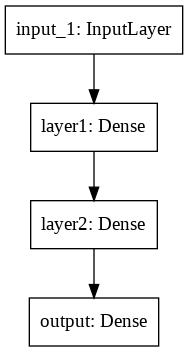

In [70]:
plot_model(model_101)

In [71]:
model_101.fit(X_train_pooled_output, Y_train_df, epochs=10, validation_split=0.2, batch_size=10,callbacks=[tensorboard_callback])

Epoch 1/10
   1/2684 [..............................] - ETA: 1s - loss: 0.6782 - auc: 0.5200 - accuracy: 0.6000WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


   2/2684 [..............................] - ETA: 1:12 - loss: 0.6805 - auc: 0.4925 - accuracy: 0.6000WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0090s vs `on_train_batch_end` time: 0.0459s). Check your callbacks.


2684/2684 [==============================] - 11s 4ms/step - loss: 0.5866 - auc: 0.7637 - accuracy: 0.6902 - val_loss: 0.4589 - val_auc: 0.8729 - val_accuracy: 0.7935
Epoch 2/10
2684/2684 [==============================] - 11s 4ms/step - loss: 0.4360 - auc: 0.8817 - accuracy: 0.8048 - val_loss: 0.4135 - val_auc: 0.8927 - val_accuracy: 0.8093
Epoch 3/10
2684/2684 [==============================] - 10s 4ms/step - loss: 0.3995 - auc: 0.9012 - accuracy: 0.8283 - val_loss: 0.3760 - val_auc: 0.9133 - val_accuracy: 0.8328
Epoch 4/10
2684/2684 [==============================] - 10s 4ms/step - loss: 0.3760 - auc: 0.9128 - accuracy: 0.8405 - val_loss: 0.4242 - val_auc: 0.8883 - val_accuracy: 0.8042
Epoch 5/10
2684/2684 [==============================] - 11s 4ms/step - loss: 0.3607 - auc: 0.9199 - accuracy: 0.8484 - val_loss: 0.3743 - val_auc: 0.9132 - val_accuracy: 0.8350
Epoch 6/10
2684/2684 [==============================] - 11s 4ms/step - loss: 0.3541 - auc: 0.9226 - accuracy: 0.8528 - val_los

In [72]:
from sklearn.metrics import classification_report

y_pred = model_101.predict(X_test_pooled_output, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

132/132 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      4221
           1       0.89      0.86      0.87      4167

    accuracy                           0.88      8388
   macro avg       0.88      0.88      0.88      8388
weighted avg       0.88      0.88      0.88      8388



In [73]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score,confusion_matrix
print('Accuracy:', accuracy_score(y_test, y_pred_bool))

Accuracy: 0.8773247496423462
